# Human Activity Recognition using Tensorflow

This is an exercise to implement a few deep learning models for recognising human activities (like walking, standing, etc) from sensor data (accelerometer and gyroscope) collected from mobile phones.

We use Jason Brownlee's tutorial (https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) as a source of inspiration and look to implement the models in Tensorflow.

I did a technical test recently that required me to take the models in the above article and convert them to PyTorch and see if I could beat the accuracies reported. 

This notebook is to do the same thing, but with Tensorflow (and Keras).


## The Dataset

As the tutorial suggests, we are going to use the same dataset - [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)


The dataset contains sensor data recorded for the following activities:

    Walking
    Walking Upstairs
    Walking Downstairs
    Sitting
    Standing
    Laying

The sensor data is made up of accelerometer data (x,y and z) and gyroscope data (angular velocity), with observations recorded at 50Hz.

Please refer to Jason's article above for a detailed description of the dataset, but in summary, the data is already pre-processes and split into windows of 128 data points (2.56 seconds) with a 50% overlap between adjacent rows.

The dataset contains a bunch of engineered features, but for this exercise we will only use three sets of raw features:
    body acceleration (x,y,z)
    body gyroscope (x,y,z)
    total acceleration(x,y,z)
    
That is, 9 features for every observation of 128 data points.

The first step is to load the data and see what it looks like

In [1]:
# All the imports in one place
import os
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt


### DataLoader

We need a data loader to extract data from the txt files and format it for us

In [2]:
class HARDataLoader:
    def __init__(self, data_root):
        self.data_root = data_root
        
    def pre_operation(self, **kwargs):
        pass
    
    def post_operation(self, **kwargs):
        X = kwargs.get("X", None)
        y = kwargs.get("y", None)
        return X, y
       

    # load a single file as a numpy array
    def load_file(self, filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values

    # load a list of files into a 3D array of [samples, features, timesteps]
    def load_group(self, filenames, prefix=''):
        loaded = list()
        for name in filenames:
            data = self.load_file(prefix + name)
            loaded.append(data)
        
        # stack group and transpose to (samples, features, timesteps)
        loaded = np.dstack(loaded).transpose(0,2,1)
        return loaded

    # load a dataset group, such as train or test
    def load_dataset_group(self, group):
        filepath = os.path.join(self.data_root, group, 'Inertial Signals/')
        # load all 9 files as a single array
        filenames = list()
        # total acceleration
        filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
        # body acceleration
        filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
        # body gyroscope
        filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
        # load input data
        X = self.load_group(filenames, filepath)
        # load class output
        y = self.load_file(os.path.join(self.data_root, group, 'y_'+group+'.txt'))
        return X, y

    # load the dataset, returns train and test X and y elements
    def load_dataset(self, **kwargs):
        
        train_test = kwargs.get("train_test", "train")
        
        self.pre_operation(**kwargs)
        
        # load all train
        X, y = self.load_dataset_group(train_test)
        
        # zero-offset class values
        y = y - 1
        
        X, y = self.post_operation(X=X, y=y)
        
        return X, y
    
    def load_labels(self):
        labels_file = os.path.join(self.data_root, 'activity_labels.txt')
        return list(pd.read_csv(labels_file, header=None, delim_whitespace=True)[1].array)

    def to_categorical(self, y, num_classes):
        """ 1-hot encodes a tensor """
        return np.eye(num_classes, dtype='uint8')[y]
    
    # standardize data
    def scale_data(self, trainX, testX, standardize):
        # remove overlap
        cut = int(trainX.shape[1] / 2)
        longX = trainX[:, -cut:, :]
        # flatten windows
        longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
        # flatten train and test
        flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
        flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
        # standardize
        if standardize:
            s = StandardScaler()
            # fit on training data
            s.fit(longX)
            # apply to training and test data
            longX = s.transform(longX)
            flatTrainX = s.transform(flatTrainX)
            flatTestX = s.transform(flatTestX)
        # reshape
        flatTrainX = flatTrainX.reshape((trainX.shape))
        flatTestX = flatTestX.reshape((testX.shape))
        return flatTrainX, flatTestX

### Test the HARDataLoader

In [45]:
dl = HARDataLoader('./UCI_HAR_Dataset')

# Load the dataset
train_X, train_y = dl.load_dataset(train_test='train') 
test_X, test_y = dl.load_dataset(train_test='test')


print("Training Data:", train_X.shape, train_y.shape)
print("Testing Data:", test_X.shape, test_y.shape)

# Make tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))


Training Data: (7352, 9, 128) (7352, 1)
Testing Data: (2947, 9, 128) (2947, 1)


# Training and evaluating the model

We are going to evaluate various models with various hyper-parameters.
For this, let's define a framework to make it easy for us to iterate.

Below, we define classes called `Experiment` and `ComparativeExperiment` and we create objects of these classes to run our experiments.

A simple example is

```
# define a config dictionary object with all the parameters
config = dict(
    # ---- network parameters
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    
    # ---- training parameters
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    verbose = 0
)

# create the experiment object
experiment1 = Experiment(config)

# run the experiment.
experiment1.run()

```

Once a Model class is defined (as shown after the next two cells), you can run different variations of experiments by changing the parameters in the config.


In [327]:
class Experiment:
    def __init__(self, config):
        self.config = config
        self.best_predictions = []
        self.actuals = []
        self.best_score = 0.0
        self.best_model = None
        self.labels=[]
        self.verbose = config.get("verbose", 0)
        
        
    '''
        Function to update the config.
        Should be called by the experimenter is config needs to be 
        updated between experiment runs.
    '''
    def update_config(self, config):
        self.config = config
    
    '''
        Trains the network for n epochs and returns an accuracy score
    '''
    def train_and_evaluate(self, train_X, train_y, test_X, test_y):

        net_class = self.config.get("net_class", None)
        
        # We need the class name of the network to create dynamically.
        if net_class is None:
            print("net_class not supplied.")
            return
        
        # Create the net object from the class name. 
        model = globals()[net_class](self.config)
        
        
        # Get all the config parameters
        lr = self.config.get("lr", 0.01)
        batch_size = self.config.get("batch_size", 32)
        epochs = self.config.get("epochs_per_repeat",10)
        
        optimiser = tf.keras.optimizers.Adam(learning_rate=lr)
        
        # Compile the model
        model.compile(optimizer=optimiser,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        

        # Train the model
        model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=self.verbose)
        
        # Evaluation
        accuracy, actuals, predictions = self.evaluate(model, test_X, test_y)
        if accuracy > self.best_score:
            self.best_score = accuracy
            self.best_predictions = predictions
            self.best_model = model
            self.actuals = actuals
        return accuracy

    
    def evaluate(self, model, test_X, test_y):

        test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y)).repeat(1).batch(128)
        predictions = []
        actuals = []
        total_test_size = 0
        correct = 0

        for X, y in test_dataset:
            y = y.numpy().reshape(-1)
            logits = model.predict(X)
            out = tf.nn.softmax(logits, axis=1, name=None)
            predicted = np.argmax(out, axis=1)
            predictions.extend(predicted.tolist())
            actuals.extend(y.tolist())
            correct += (predicted == y).sum()
        accuracy = correct * 100. / len(actuals)
        return accuracy, actuals, predictions

    
    '''
        summarize scores
    '''
    def summarize_results(self):
        m, s = np.mean(self.scores), np.std(self.scores)
        repeats = self.config.get("repeats", 10)
        print('Accuracy over {0} trials: {1:.3f}% (+/-{2:.3f})'.format(repeats, m, s))
        
        print('Best model accuracy: {0:.3f}%'.format(np.max(self.scores)))
        
        # confusion matrix for best scores
        conf_matrix = confusion_matrix(self.actuals, self.best_predictions)
        df_cm = pd.DataFrame(conf_matrix, index = self.labels, columns = self.labels)
        plt.figure(figsize = (3,3))
        plt.title('Confusion Matrix For Best Run', fontsize=20)
        sns.heatmap(df_cm, annot=True, fmt='g')
        plt.show()
        if len(self.scores) > 1:
            self._plot(self.scores)

    # helper function to plot scores
    def _plot(self, data):
        plt.figure(figsize = (3,3))
        sns.lineplot(range(1, len(data) + 1), data)
        
        plt.xlabel('Repeats', fontsize=14)
        plt.ylabel('Accuracy(%)', fontsize=14)
        plt.title('Test Accuracy', fontsize=20)
        plt.show()

    ''' 
        Run the experiment
    '''
    def run(self):
        
        # load data
        har_dataloader = HARDataLoader('./UCI_HAR_Dataset')
        train_X, train_y = har_dataloader.load_dataset(train_test='train') 
        test_X, test_y = har_dataloader.load_dataset(train_test='test')
        self.labels = har_dataloader.load_labels()
        
        # scale data
        if self.config.get("standardize", False):
            train_X, test_X = har_dataloader.scale_data(train_X, test_X, standardize=True)

        # repeat experiment
        self.scores = list()
        repeats = self.config.get("repeats", 10)
        batch_size = self.config.get("batch_size", 32)
        for r in range(repeats):
            # train and evaluate the model
            score = self.train_and_evaluate(train_X, train_y, test_X, test_y)
            print('#{0}: {1:.3f}'.format(r+1, score))
            self.scores.append(score)
        # summarize results
        self.summarize_results()

#1: 81.880
Accuracy over 1 trials: 81.880% (+/-0.000)
Best model accuracy: 81.880%


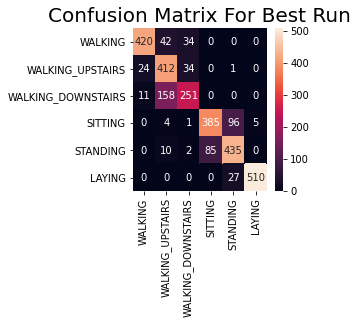

In [328]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 1,
    epochs_per_repeat = 1,
    lr = 0.001,
    batch_size = 32,
    init_weights = True, # Initialises weights using kaiming_uniform_()
    verbose = 0
)
experiment1 = Experiment(config)
experiment1.run()

#### Compatative Experiments
Use this to perform comparative experiments where
    you want to try different values or one of the 
    (hyper)parameters.
    
Note: To keep weights initialised to the same values,
torch.manual_seed() is used to set the random seed.
This makes sure results between runs of experiments 
are comparable.

Use "repeat_on" parameter of the config to specify which parameter 
you want to repeat the experiments on.
Then use the parameter setting as an array of values.
        
Eg:
    
    config = dict(
        # ---- network parameters
        net_class = "CNN_1D_Model",
        n_filters = 64,
        kernel_size = 3,
        dropout = 0.5,

        # ---- training parameters
        epochs_per_repeat = 10,
        lr = 0.001,
        repeat_on = "batch_size", # Which parameter do we want to repeat the experiment on
        batch_size = [8,16,32,64,128,256] # list of different values for the parameter
        
    )
    comparative_experiment = ComparativeExperiment(config)
    comparative_experiment.run()
    

In [348]:
class ComparativeExperiment():

    def __init__(self, config):
        self.config = config
        
    ''' 
        Run the experiment
    '''
    def run(self):
        
        # which parameter are we repeating experiments on?
        repeat_on = self.config.get("repeat_on", "")
        print("Experiments on changing {}".format(repeat_on))
        if repeat_on != "":
            repeats = self.config.get(repeat_on, [])
            config = copy.copy(self.config)
            for repeat in repeats:
                print("Starting experiment with {0}={1}".format(repeat_on, repeat))
                config[repeat_on] = repeat
                config["repeats"] = 1
                config["random_seed"] = 28
                experiment = Experiment(config)
                experiment.run()


# CNN Model 1

Let's define the first CNN model with 1D conv layers as used in the article.
The network architecture is:

`Conv1D -> Conv1D -> Dropout -> MaxPool -> FullyConnected -> FullyConnected`

In [336]:
class CNN_1D_Model(keras.Sequential):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        n_filters = self.config.get("n_filters", 64)
        kernel_size = self.config.get("kernel_size", 3)
        dropout = self.config.get("dropout", 0.5)
        
        self.add(keras.layers.Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(9,128), padding='same'))
        self.add(keras.layers.Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        self.add(keras.layers.Dropout(dropout))
        self.add(keras.layers.MaxPooling1D(pool_size=2))
        self.add(keras.layers.Flatten())
        self.add(keras.layers.Dense(100, activation='relu'))
        self.add(keras.layers.Dense(6))
            
        

In [306]:
config = dict(
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    
    verbose = False
)
model = CNN_1D_Model(config)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])


In [307]:
model.fit(train_X, train_y, epochs=10)

Train on 7352 samples
Epoch 1/10
7352/7352 [==============================] - 1s 180us/sample - loss: 0.6448 - accuracy: 0.7427
Epoch 2/10
7352/7352 [==============================] - 1s 135us/sample - loss: 0.3016 - accuracy: 0.8871
Epoch 3/10
7352/7352 [==============================] - 1s 136us/sample - loss: 0.2359 - accuracy: 0.9067
Epoch 4/10
7352/7352 [==============================] - 1s 140us/sample - loss: 0.1936 - accuracy: 0.9232
Epoch 5/10
7352/7352 [==============================] - 1s 136us/sample - loss: 0.1637 - accuracy: 0.9334
Epoch 6/10
7352/7352 [==============================] - 1s 135us/sample - loss: 0.1560 - accuracy: 0.9357
Epoch 7/10
7352/7352 [==============================] - 1s 138us/sample - loss: 0.1450 - accuracy: 0.9421
Epoch 8/10
7352/7352 [==============================] - 1s 138us/sample - loss: 0.1311 - accuracy: 0.9449
Epoch 9/10
7352/7352 [==============================] - 1s 137us/sample - loss: 0.1192 - accuracy: 0.9493
Epoch 10/10
7352/7352 [=

### Experiment 1

Our first experiment is to re-create the first experiment from the article.
1DCNN model, trained for 10 epochs with batch size of 32. Repeating 10 times.

#1: 89.583
#2: 89.583
#3: 89.141
#4: 90.499
#5: 88.870
#6: 88.836
#7: 89.311
#8: 87.445
#9: 88.327
#10: 88.361
Accuracy over 10 trials: 88.996% (+/-0.798)
Best model accuracy: 90.499%


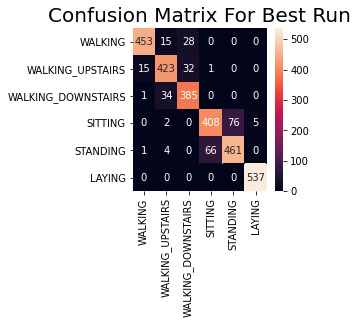

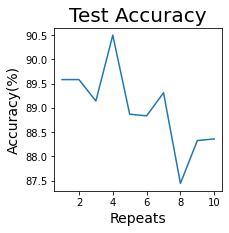

In [330]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    verbose = 0
)
experiment1 = Experiment(config)
experiment1.run()

### Experiment 2

Trying the same 1D model but with 5 epochs per repeat to see if training longer is deteriorating the performance.

#1: 86.189
#2: 88.361
#3: 87.682
#4: 89.209
#5: 86.155
#6: 87.038
#7: 86.902
#8: 86.189
#9: 88.361
#10: 86.088
Accuracy over 10 trials: 87.218% (+/-1.070)
Best model accuracy: 89.209%


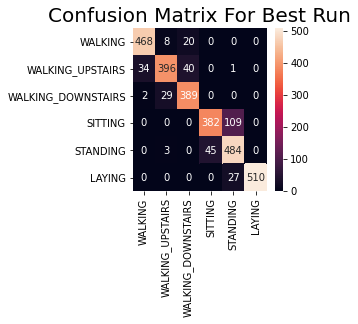

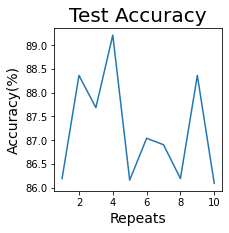

In [331]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 5,
    lr = 0.001,
    batch_size = 32,
    verbose = 0
)
experiment2 = Experiment(config)
experiment2.run()


So, 5 epochs is not better than 10

### Experiment 3

Trying the same 1D models with slower learning rate, but 50 epochs. Let's try for 1 repeat.

#1: 91.653
Accuracy over 1 trials: 91.653% (+/-0.000)
Best model accuracy: 91.653%


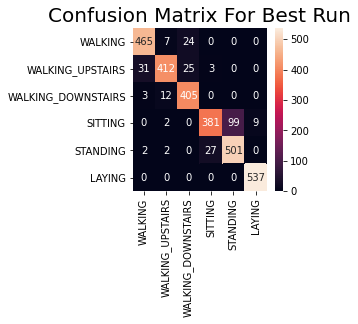

In [333]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    repeats = 1,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32,
    verbose = 0
)
experiment3 = Experiment(config)
experiment3.run()

### Observation

As you can see from the above experiments, the accuracies are consistent with those in the article.


### Experiment 5

Increased the kernel size in the conv1D layers to 5.
Trying out 10 repeats of 10 epochs

#1: 88.497
#2: 90.261
#3: 90.431
#4: 89.684
#5: 89.922
#6: 89.888
#7: 89.243
#8: 89.922
#9: 90.974
#10: 89.379
Accuracy over 10 trials: 89.820% (+/-0.650)
Best model accuracy: 90.974%


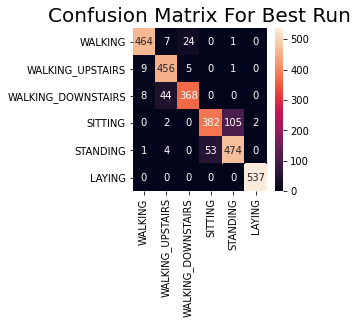

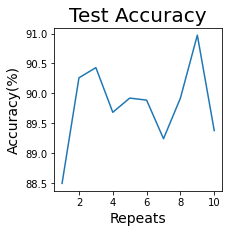

In [337]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 5,
    dropout = 0.5,
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    verbose = 0
)
experiment5 = Experiment(config)
experiment5.run()

# LSTM Model

I was able to get good consistent results with the 1DCNN model, so looked at LSTM models to see if I can improve the accuracy.

In [338]:
class LSTMModel(keras.Sequential):
    def __init__(self, config):
        super(LSTMModel, self).__init__()
        
        self.config = config
        
        # Number of units
        self.num_units = self.config["num_units"]

        # Build the LSTM
        self.add(keras.layers.LSTM(self.num_units, input_shape=(9,128)))
        self.add(keras.layers.Dense(6))


### Experiment 6

1D Convolution models are not performing great, so trying a simple LSTM model to start with.
Train for 10 epochs for 1 repeat.

#1: 88.259
Accuracy over 1 trials: 88.259% (+/-0.000)
Best model accuracy: 88.259%


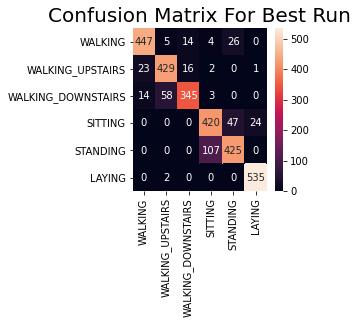

In [342]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    
    num_units = 100,
    #-----
    repeats = 1,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    verbose=0
)
experiment6 = Experiment(config)
experiment6.run()

### Experiment 7

Trying the same LSTM model for 50 epocs

#1: 86.630
Accuracy over 1 trials: 86.630% (+/-0.000)
Best model accuracy: 86.630%


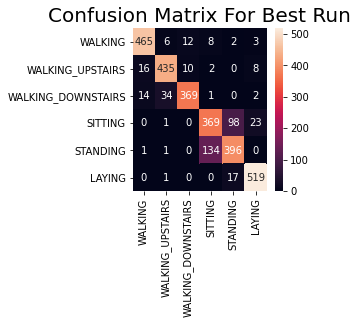

In [344]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    num_units = 100,
    #-----
    repeats = 1,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32
)
experiment7 = Experiment(config)
experiment7.run()

### Experiment 8
LSTM with 10 repeats

#1: 87.241
#2: 87.581
#3: 88.870
#4: 86.189
#5: 90.058
#6: 87.581
#7: 88.056
#8: 88.802
#9: 89.006
#10: 89.413
Accuracy over 10 trials: 88.280% (+/-1.099)
Best model accuracy: 90.058%


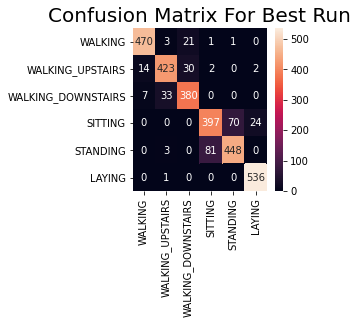

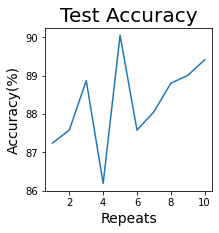

In [346]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    
    num_units = 100,
    #-----
    repeats = 10,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = 32,
    verbose=0
)
experiment8 = Experiment(config)
experiment8.run()

## LSTM isn't working much better than 1DConv model

This simple LSTM is not working any better than the 1DConv model.

### Comparative Experiment 1

This is one experiment to show how a comparative experiment works. I could expand further on what hyper-parameters can be experimented with. Perhaps in the next version.

Let's try the 1DConv model with different batch sizes.

Experiments on changing batch_size
Starting experiment with batch_size=8
#1: 90.261
Accuracy over 1 trials: 90.261% (+/-0.000)
Best model accuracy: 90.261%


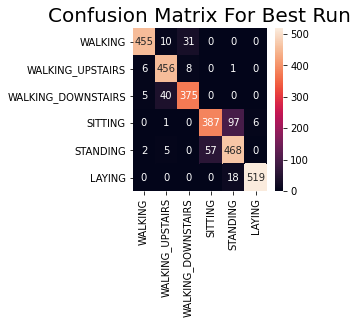

Starting experiment with batch_size=16
#1: 90.770
Accuracy over 1 trials: 90.770% (+/-0.000)
Best model accuracy: 90.770%


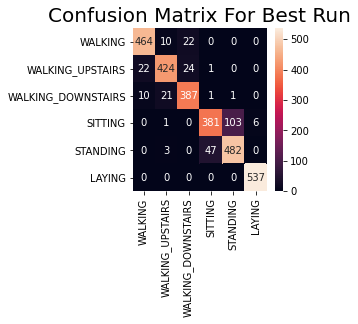

Starting experiment with batch_size=32
#1: 88.599
Accuracy over 1 trials: 88.599% (+/-0.000)
Best model accuracy: 88.599%


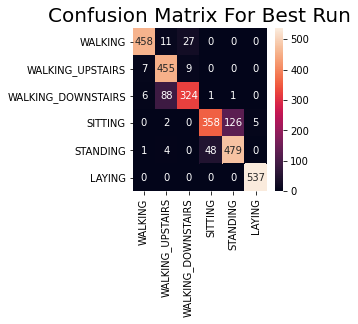

Starting experiment with batch_size=64
#1: 90.058
Accuracy over 1 trials: 90.058% (+/-0.000)
Best model accuracy: 90.058%


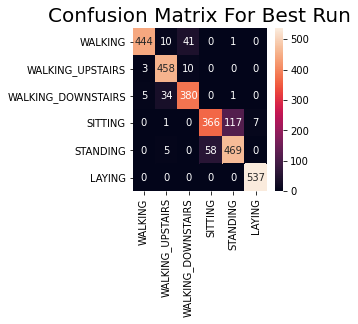

Starting experiment with batch_size=128
#1: 89.922
Accuracy over 1 trials: 89.922% (+/-0.000)
Best model accuracy: 89.922%


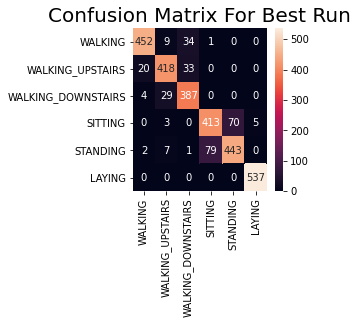

Starting experiment with batch_size=256
#1: 88.191
Accuracy over 1 trials: 88.191% (+/-0.000)
Best model accuracy: 88.191%


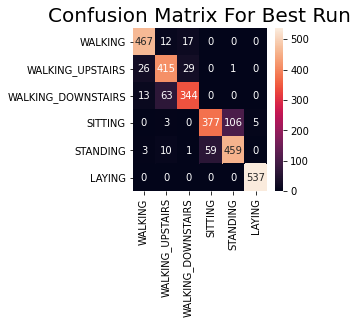

In [349]:
config = dict(
    net_class = "CNN_1D_Model",
    n_filters = 64,
    kernel_size = 3,
    dropout = 0.5,
    epochs_per_repeat = 10,
    lr = 0.001,
    batch_size = [8,16,32,64,128,256],
    repeat_on = "batch_size"
)
comparative_experiment = ComparativeExperiment(config)
comparative_experiment.run()

Batch size 64 seems to be the best.

# Conclusions

This notebook was put together in a day, so its not perfect. A few observations in no particular order.

- Given the very minimal improvement in accuracy (in the article) after standardising the dataset, I did not try it myself. But it is definitely something I would try.


- The article suggests a multi-headed CNN to improve the performance. I wanted to try something different, so I tried the LSTM model and was able to get consistent good performance with a simple model.

- The model classes are built using keras.Sequential API. I'd like to try the Functional API in the next version.

- I could try other flavours of the LSTM but given the training takes considerably longer, I did not experiment further.


- The experimentation framework seems like a good starting point and I'd improve it going forward.
